This notebook generates the plots to make Figure 1 and Figure 2 in the paper.

**Figure 1:**

For each signal dataset, we create a ROC curve plot which compares the curves for 2D OT, 3D OT, 3D OT+anomaly kNN. It also reports the AUC for these methods as well as the One-class SVM (since its ROC curve is trivial).

**Figure 2:**

For each signal dataset, we create an SI curve plot which compares the curves for 2D OT, 3D OT, 3D OT+anomaly kNN and reports the max SI value and its corresponding TPR.

In [1]:
NSIGFIGS = 4
NREPEAT  = 5
MINTPR   = 0.2
BASEPATH = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OT_anomaly_detection/'

In [2]:
sigNameList    = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
methodNameList = ['2D OT', '3D OT', '3D OT+anomaly kNN', '3D OT+One-class SVM']
fileNameList   = ['finalScoreDict_2D_nEvents1000_nRepeat5_eventToEnsembleTypeMIN.npz',
                  'finalScoreDict_3D_nEvents1000_nRepeat5_eventToEnsembleTypeMIN.npz',
                  'finalScoreDict_3DanomalykNN_nEvents1000_nRepeat5.npz',
                  'finalScoreDict_3DoneClassSVM_nEvents1000_nRepeat5.npz']

# Preliminaries

## Information about data

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for testing out new methods!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022),
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [3]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

## Google Drive preliminaries (since we're running on Google Colab)

In [4]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [5]:
#-- Set base directory and data directory path --#
basePath   = BASEPATH
dataPath   = 'data/'
resultsPath = 'results/npz_Files/'

## Import libraries

In [6]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

import os.path

import json

## Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [7]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OT_anomaly_detection/functions/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OT_anomaly_detection/functions
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 8.7 MB/s eta 0:00:00


# Load results for each method

In [8]:
resultsDict = {}

for method in methodNameList:
  resultsDict[method] = {}

  resultsDict[method]['avStdQuantities'] = {}

In [9]:
#-- Load results --#

"""
  We loop over the saved .npz files of mean and std of results
  Filenames corresponding to each method are given in fileNameList
  We require that there is a top-level key 'avStdQuantities' with the following substructure
    'avStdQuantities'
        'sig_A'
            'auc'
              'mean'
              'std'
            'fpr'
              ...
            'SI'
              ...
            'fprInv'
              ...
            'F1'
              ...
        'sig_h0'
            ...
        'sig_hch'
            ...
        'sig_LQ'
            ...
"""

for i in range(len(fileNameList)):

  filename = basePath + resultsPath + fileNameList[i]
  method   = methodNameList[i]

  if os.path.exists(filename):
    dummyDict = np.load(filename, allow_pickle=True)

    # Unpack contents
    scoreDict = {}
    for key in dummyDict.files:
      scoreDict[key] = dummyDict[key].item()

    # Assign avStdQuantities to results Dict
    resultsDict[method]['avStdQuantities'] = scoreDict['avStdQuantities']
  else:
    print("Error: Cannot find file %s"%filename)

# Alternate color scheme code

In [10]:
# Define colors to use for 4 method types
METHOD_COLOR_ARR = np.array([ RGBAtoRGBAtuple((1, 41, 95, 1), TYPE='list'),
                              RGBAtoRGBAtuple((124, 60, 83, 1), TYPE='list'),
                              RGBAtoRGBAtuple((74, 82, 20, 1), TYPE='list'),
                              RGBAtoRGBAtuple((196, 163, 110, 1), TYPE='list')
                             ])

# Figure 1

## Signal case $A$

In [ ]:
sigAlias = sigAliasList[0]
sigName  = sigNameList[0]
saveFigPath = basePath + 'paperPlots/ROC/' + 'ROC_curve_A.pdf'

### Make plot

In [ ]:
av_fprList, std_fprList = [],[]
av_aucList, std_aucList = [],[]

for method in methodNameList:
  av_fprList.append(resultsDict[method]['avStdQuantities'][sigAlias]['fpr']['mean'])
  std_fprList.append(resultsDict[method]['avStdQuantities'][sigAlias]['fpr']['std'])
  av_aucList.append(resultsDict[method]['avStdQuantities'][sigAlias]['auc']['mean'])
  std_aucList.append(resultsDict[method]['avStdQuantities'][sigAlias]['auc']['std'])

Saving figure to file:  /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Results/ROC_curve_A.pdf


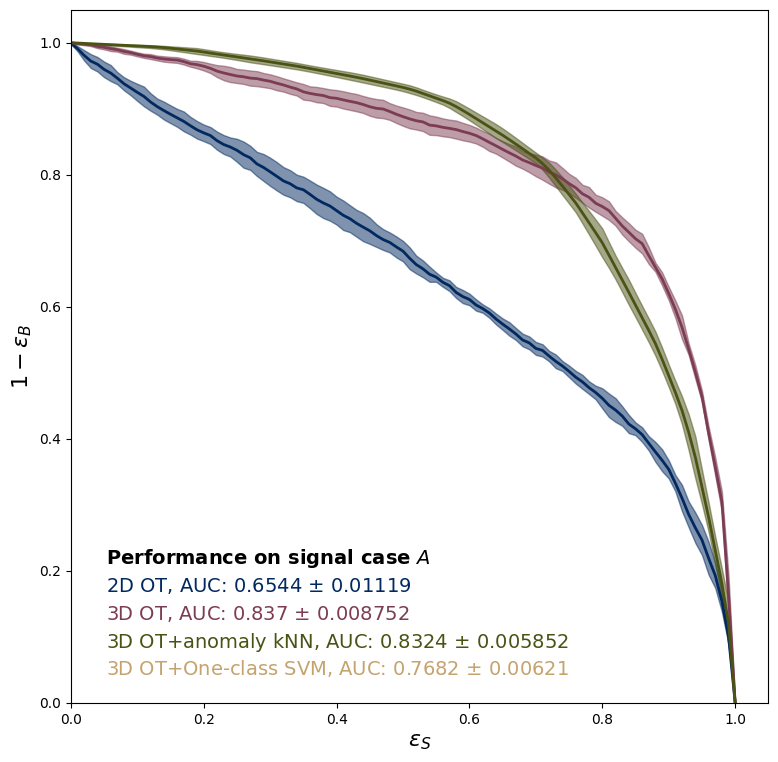

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$' # OR  r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$1 - \epsilon_B$' # OR r'Background Rejection (TNR)'
plotArgDict['title']     = r'Performance on signal case %s'%(sigName)
plotArgDict['CMAP']            = METHOD_COLOR_ARR
plotArgDict['methodNameList']  = methodNameList
plotArgDict['avAUCList']       = av_aucList
plotArgDict['stdAUCList']      = std_aucList

plotArgDict['delta_yposPerc'] = 0.04
plotArgDict['xposPerc']       = 0.05
plotArgDict['yposPerc']       = 0.2

plotROCcurve_errorBand_specificMethod(av_fprList, std_fprList, plotArgDict, TYPE='Classic', saveFigPath=saveFigPath)

## Signal case $h^0$

In [ ]:
sigAlias = sigAliasList[1]
sigName  = sigNameList[1]
saveFigPath = basePath + 'paperPlots/ROC/' + 'ROC_curve_h0.pdf'

### Make plot

In [ ]:
av_fprList, std_fprList = [],[]
av_aucList, std_aucList = [],[]

for method in methodNameList:
  av_fprList.append(resultsDict[method]['avStdQuantities'][sigAlias]['fpr']['mean'])
  std_fprList.append(resultsDict[method]['avStdQuantities'][sigAlias]['fpr']['std'])
  av_aucList.append(resultsDict[method]['avStdQuantities'][sigAlias]['auc']['mean'])
  std_aucList.append(resultsDict[method]['avStdQuantities'][sigAlias]['auc']['std'])

Saving figure to file:  /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Results/ROC_curve_h0.pdf


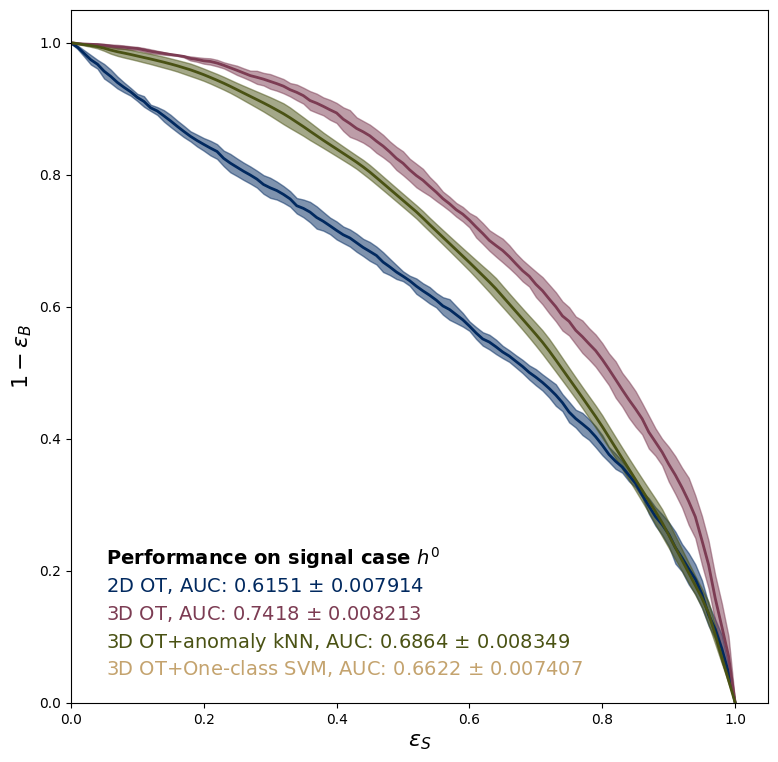

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$' # OR  r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$1 - \epsilon_B$' # OR r'Background Rejection (TNR)'
plotArgDict['title']     = r'Performance on signal case %s'%(sigName)
plotArgDict['CMAP']            = METHOD_COLOR_ARR
plotArgDict['methodNameList']  = methodNameList
plotArgDict['avAUCList']       = av_aucList
plotArgDict['stdAUCList']      = std_aucList

plotArgDict['delta_yposPerc'] = 0.04
plotArgDict['xposPerc']       = 0.05
plotArgDict['yposPerc']       = 0.2

plotROCcurve_errorBand_specificMethod(av_fprList, std_fprList, plotArgDict, TYPE='Classic', saveFigPath=saveFigPath)

## Signal case $h^{\pm}$

In [ ]:
sigAlias = sigAliasList[2]
sigName  = sigNameList[2]
saveFigPath = basePath + 'paperPlots/ROC/' + 'ROC_curve_hch.pdf'

### Make plot

In [ ]:
av_fprList, std_fprList = [],[]
av_aucList, std_aucList = [],[]

for method in methodNameList:
  av_fprList.append(resultsDict[method]['avStdQuantities'][sigAlias]['fpr']['mean'])
  std_fprList.append(resultsDict[method]['avStdQuantities'][sigAlias]['fpr']['std'])
  av_aucList.append(resultsDict[method]['avStdQuantities'][sigAlias]['auc']['mean'])
  std_aucList.append(resultsDict[method]['avStdQuantities'][sigAlias]['auc']['std'])

Saving figure to file:  /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Results/ROC_curve_hch.pdf


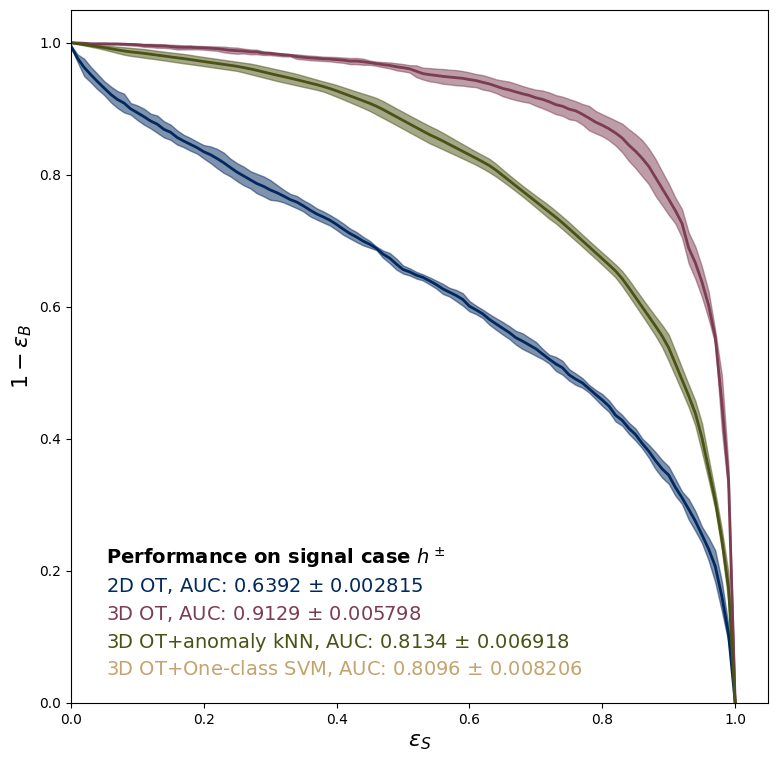

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$' # OR  r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$1 - \epsilon_B$' # OR r'Background Rejection (TNR)'
plotArgDict['title']     = r'Performance on signal case %s'%(sigName)
plotArgDict['CMAP']            = METHOD_COLOR_ARR
plotArgDict['methodNameList']  = methodNameList
plotArgDict['avAUCList']       = av_aucList
plotArgDict['stdAUCList']      = std_aucList

plotArgDict['delta_yposPerc'] = 0.04
plotArgDict['xposPerc']       = 0.05
plotArgDict['yposPerc']       = 0.2

plotROCcurve_errorBand_specificMethod(av_fprList, std_fprList, plotArgDict, TYPE='Classic', saveFigPath=saveFigPath)

## Signal case $LQ$

In [ ]:
sigAlias = sigAliasList[3]
sigName  = sigNameList[3]
saveFigPath = basePath + 'paperPlots/ROC/' + 'ROC_curve_LQ.pdf'

### Make plot

In [ ]:
av_fprList, std_fprList = [],[]
av_aucList, std_aucList = [],[]

for method in methodNameList:
  av_fprList.append(resultsDict[method]['avStdQuantities'][sigAlias]['fpr']['mean'])
  std_fprList.append(resultsDict[method]['avStdQuantities'][sigAlias]['fpr']['std'])
  av_aucList.append(resultsDict[method]['avStdQuantities'][sigAlias]['auc']['mean'])
  std_aucList.append(resultsDict[method]['avStdQuantities'][sigAlias]['auc']['std'])

Saving figure to file:  /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Results/ROC_curve_LQ.pdf


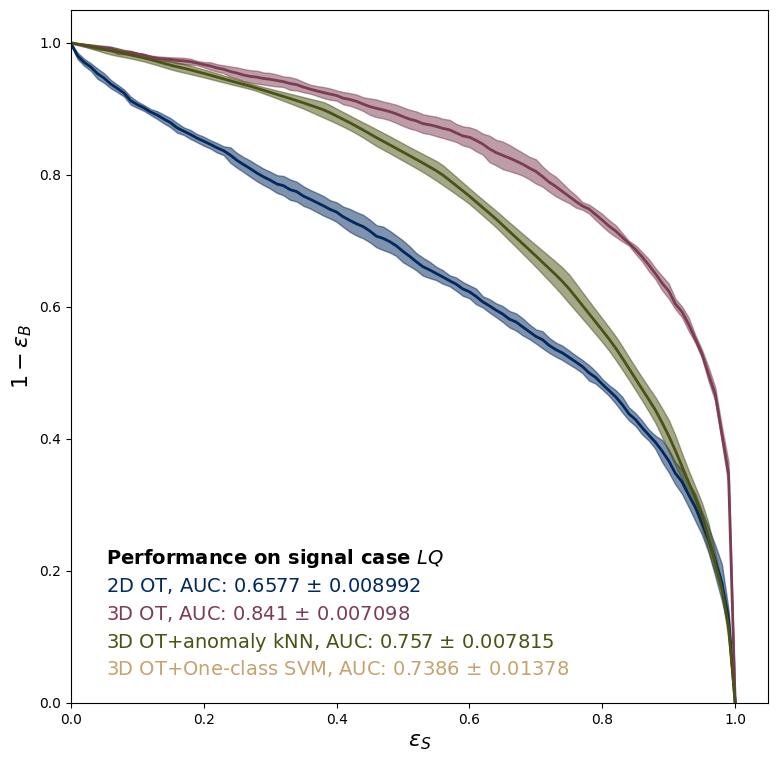

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$' # OR  r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$1 - \epsilon_B$' # OR r'Background Rejection (TNR)'
plotArgDict['title']     = r'Performance on signal case %s'%(sigName)
plotArgDict['CMAP']            = METHOD_COLOR_ARR
plotArgDict['methodNameList']  = methodNameList
plotArgDict['avAUCList']       = av_aucList
plotArgDict['stdAUCList']      = std_aucList

plotArgDict['delta_yposPerc'] = 0.04
plotArgDict['xposPerc']       = 0.05
plotArgDict['yposPerc']       = 0.2

plotROCcurve_errorBand_specificMethod(av_fprList, std_fprList, plotArgDict, TYPE='Classic', saveFigPath=saveFigPath)

# Figure 2

## Signal case $A$

In [11]:
sigAlias = sigAliasList[0]
sigName  = sigNameList[0]
saveFigPath = basePath + 'paperPlots/SI/' + 'SI_curve_A.pdf'

### Make plot

In [12]:
av_SIList, std_SIList = [],[]
av_maxSIList, std_maxSIList, corr_tprList = [],[], []

for method in methodNameList:
  av_temp  = resultsDict[method]['avStdQuantities'][sigAlias]['SI']['mean']
  std_temp = resultsDict[method]['avStdQuantities'][sigAlias]['SI']['std']

  av_SIList.append(av_temp)
  std_SIList.append(std_temp)

  av_maxSI, std_maxSI, corr_tpr = calcMaxAvSI_helper(av_temp, std_temp, minTPR=MINTPR)
  av_maxSIList.append(av_maxSI)
  std_maxSIList.append(std_maxSI)
  corr_tprList.append(corr_tpr)

Saving figure to file:  /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OT_anomaly_detection/paperPlots/SI/SI_curve_A.pdf


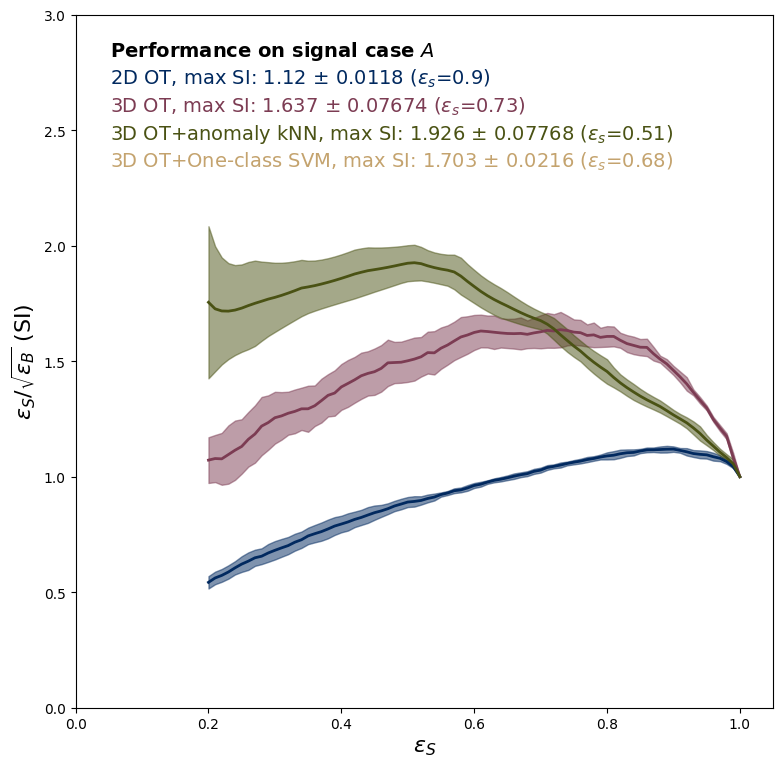

In [13]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$'
plotArgDict['yAxisLims'] = (0, 3.0)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B}$ (SI)'
plotArgDict['title']     = r'Performance on signal case %s'%(sigName)
plotArgDict['CMAP']            = METHOD_COLOR_ARR

plotArgDict['methodNameList']  = methodNameList
plotArgDict['avMaxSIList']     = av_maxSIList
plotArgDict['stdMaxSIList']    = std_maxSIList
plotArgDict['corrTPRList']     = corr_tprList
plotArgDict['delta_yposPerc'] = 0.04
plotArgDict['xposPerc']       = 0.05
plotArgDict['yposPerc']       = 0.94

plotSIcurve_errorBand_specificMethod(av_SIList, std_SIList, plotArgDict, minTPR=MINTPR, NSIGFIGS=NSIGFIGS, saveFigPath=saveFigPath)

## Signal case $h^0$

In [14]:
sigAlias = sigAliasList[1]
sigName  = sigNameList[1]
saveFigPath = basePath + 'paperPlots/SI/' + 'SI_curve_h0.pdf'

### Make plot

In [15]:
av_SIList, std_SIList = [],[]
av_maxSIList, std_maxSIList, corr_tprList = [],[], []

for method in methodNameList:
  av_temp  = resultsDict[method]['avStdQuantities'][sigAlias]['SI']['mean']
  std_temp = resultsDict[method]['avStdQuantities'][sigAlias]['SI']['std']

  av_SIList.append(av_temp)
  std_SIList.append(std_temp)

  av_maxSI, std_maxSI, corr_tpr = calcMaxAvSI_helper(av_temp, std_temp, minTPR=MINTPR)
  av_maxSIList.append(av_maxSI)
  std_maxSIList.append(std_maxSI)
  corr_tprList.append(corr_tpr)

Saving figure to file:  /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OT_anomaly_detection/paperPlots/SI/SI_curve_h0.pdf


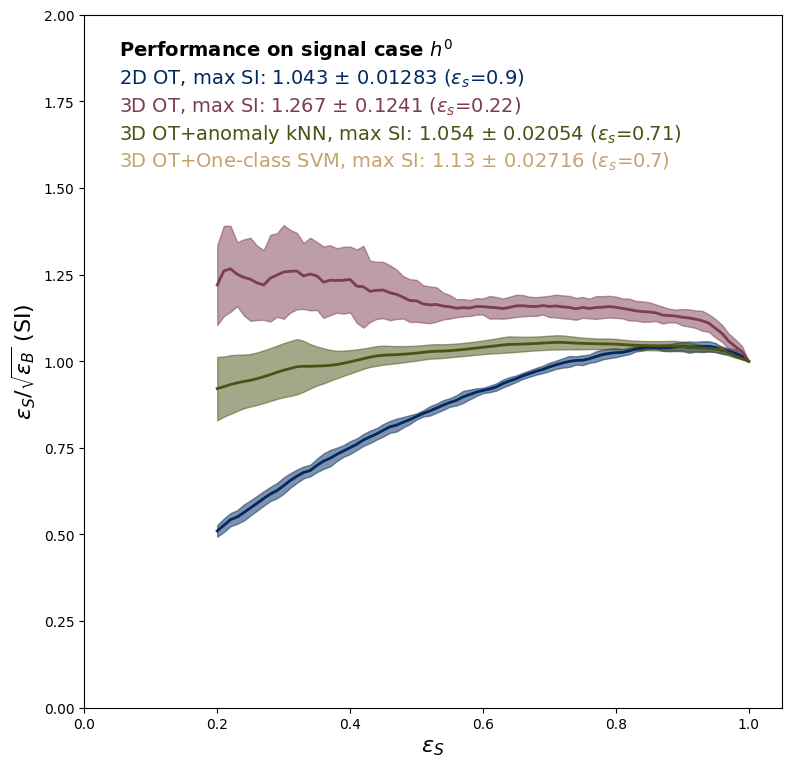

In [16]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$'
plotArgDict['yAxisLims'] = (0, 2.)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B}$ (SI)'
plotArgDict['title']     = r'Performance on signal case %s'%(sigName)
plotArgDict['CMAP']            = METHOD_COLOR_ARR

plotArgDict['methodNameList']  = methodNameList
plotArgDict['avMaxSIList']     = av_maxSIList
plotArgDict['stdMaxSIList']    = std_maxSIList
plotArgDict['corrTPRList']     = corr_tprList
plotArgDict['delta_yposPerc'] = 0.04
plotArgDict['xposPerc']       = 0.05
plotArgDict['yposPerc']       = 0.94

plotSIcurve_errorBand_specificMethod(av_SIList, std_SIList, plotArgDict, minTPR=MINTPR, NSIGFIGS=NSIGFIGS, saveFigPath=saveFigPath)

## Signal case $h^{\pm}$

In [17]:
sigAlias = sigAliasList[2]
sigName  = sigNameList[2]
saveFigPath = basePath + 'paperPlots/SI/' + 'SI_curve_hch.pdf'

### Make plot

In [18]:
av_SIList, std_SIList = [],[]
av_maxSIList, std_maxSIList, corr_tprList = [],[], []

for method in methodNameList:
  av_temp  = resultsDict[method]['avStdQuantities'][sigAlias]['SI']['mean']
  std_temp = resultsDict[method]['avStdQuantities'][sigAlias]['SI']['std']

  av_SIList.append(av_temp)
  std_SIList.append(std_temp)

  av_maxSI, std_maxSI, corr_tpr = calcMaxAvSI_helper(av_temp, std_temp, minTPR=MINTPR)
  av_maxSIList.append(av_maxSI)
  std_maxSIList.append(std_maxSI)
  corr_tprList.append(corr_tpr)

Saving figure to file:  /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OT_anomaly_detection/paperPlots/SI/SI_curve_hch.pdf


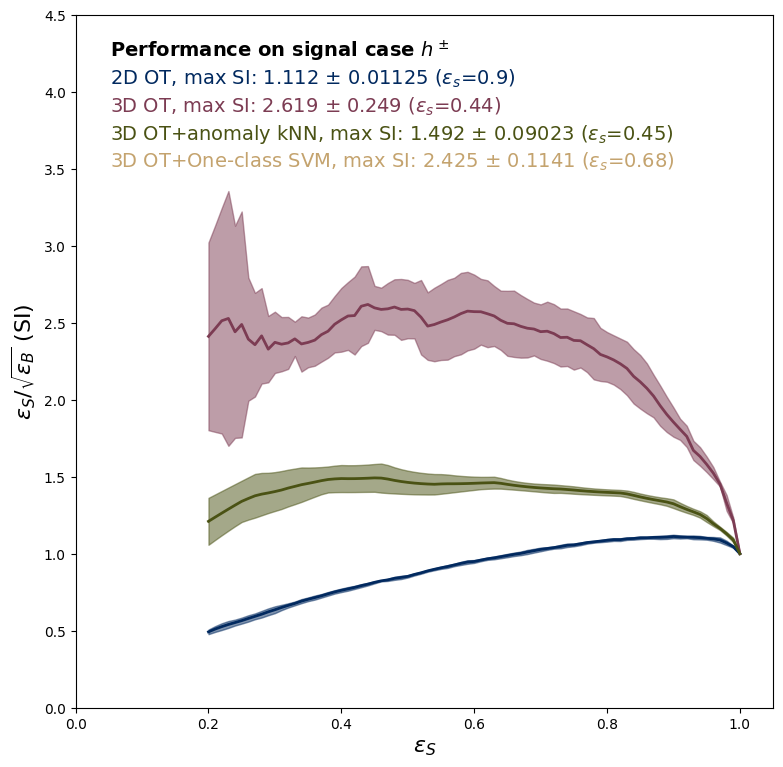

In [19]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$'
plotArgDict['yAxisLims'] = (0, 4.5)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B}$ (SI)'
plotArgDict['title']     = r'Performance on signal case %s'%(sigName)
plotArgDict['CMAP']            = METHOD_COLOR_ARR

plotArgDict['methodNameList']  = methodNameList
plotArgDict['avMaxSIList']     = av_maxSIList
plotArgDict['stdMaxSIList']    = std_maxSIList
plotArgDict['corrTPRList']     = corr_tprList
plotArgDict['delta_yposPerc'] = 0.04
plotArgDict['xposPerc']       = 0.05
plotArgDict['yposPerc']       = 0.94

plotSIcurve_errorBand_specificMethod(av_SIList, std_SIList, plotArgDict, minTPR=MINTPR, NSIGFIGS=NSIGFIGS, saveFigPath=saveFigPath)

## Signal case $LQ$

In [20]:
sigAlias = sigAliasList[3]
sigName  = sigNameList[3]
saveFigPath = basePath + 'paperPlots/SI/' + 'SI_curve_LQ.pdf'

### Make plot

In [21]:
av_SIList, std_SIList = [],[]
av_maxSIList, std_maxSIList, corr_tprList = [],[], []

for method in methodNameList:
  av_temp  = resultsDict[method]['avStdQuantities'][sigAlias]['SI']['mean']
  std_temp = resultsDict[method]['avStdQuantities'][sigAlias]['SI']['std']

  av_SIList.append(av_temp)
  std_SIList.append(std_temp)

  av_maxSI, std_maxSI, corr_tpr = calcMaxAvSI_helper(av_temp, std_temp, minTPR=MINTPR)
  av_maxSIList.append(av_maxSI)
  std_maxSIList.append(std_maxSI)
  corr_tprList.append(corr_tpr)

Saving figure to file:  /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OT_anomaly_detection/paperPlots/SI/SI_curve_LQ.pdf


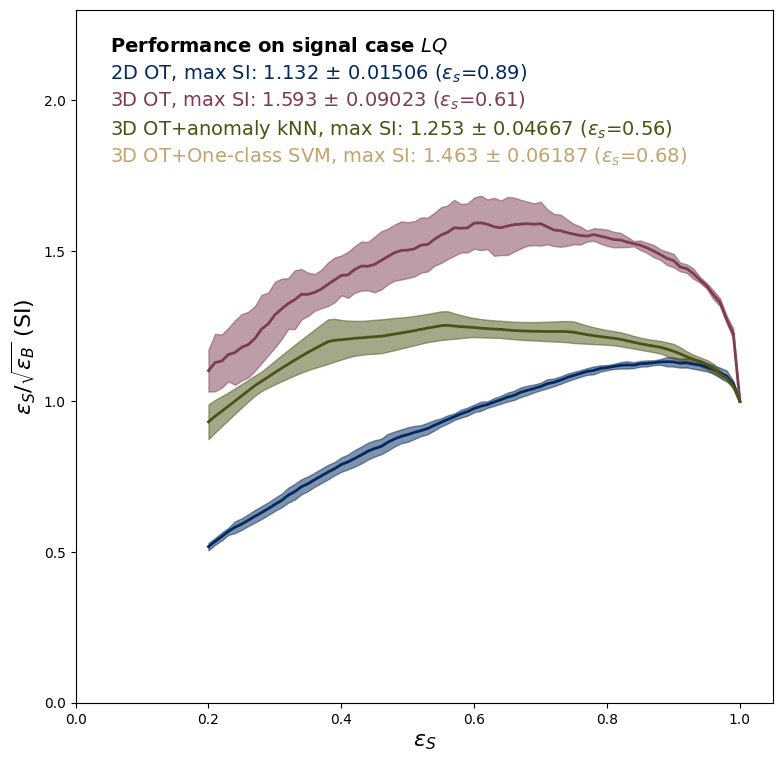

In [22]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$'
plotArgDict['yAxisLims'] = (0, 2.3)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B}$ (SI)'
plotArgDict['title']     = r'Performance on signal case %s'%(sigName)
plotArgDict['CMAP']            = METHOD_COLOR_ARR

plotArgDict['methodNameList']  = methodNameList
plotArgDict['avMaxSIList']     = av_maxSIList
plotArgDict['stdMaxSIList']    = std_maxSIList
plotArgDict['corrTPRList']     = corr_tprList
plotArgDict['delta_yposPerc'] = 0.04
plotArgDict['xposPerc']       = 0.05
plotArgDict['yposPerc']       = 0.94

plotSIcurve_errorBand_specificMethod(av_SIList, std_SIList, plotArgDict, minTPR=MINTPR, NSIGFIGS=NSIGFIGS, saveFigPath=saveFigPath)